In [1]:
import os
import numpy as np
import time
import copy
import sys

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [2]:
#folder = "/home/kristjan/local_work/asetk_example1/for_restart_file/"
#file_basis_set = folder + "BR"
#file_xyz = folder + "anthracene.xyz"
#file_restart = folder + "ANTHRACENE-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"


#folder = "/home/kristjan/local_work/cp2k_na_ribbon/scf/"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"
#file_basis_set = folder + "BR"
#file_xyz = folder + "p_opt_centered.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_hartree = folder + "PROJ-HART-v_hartree-1_0.cube"


folder = "/home/kristjan/sshfs/daint_scratch/cp2k_prec_9agnr/"
file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"
file_basis_set = folder + "BR"
file_xyz = folder + "p.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_hartree = folder + "V_HARTREE-v_hartree-1_0.cube"

In [3]:
emin = -0.5
emax =  0.5

In [4]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Read cp2k out: %.3f" % (time.time()-time1))

time1 = time.time()
at_positions, at_elems = cu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

# RESTART FILE

time1 = time.time()
morb_composition, morb_comp_rev, morb_energies, morb_occs, ref_energy = cu.load_restart_wfn_file(
                                                                            file_restart, emin, emax, fermi)
print("Found %d orbitals" % len(morb_energies))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.235
Read cp2k out: 0.236
Read xyz: 0.078
Read basis sets: 0.260
First molecular index in energy range:  5075
Found 152 orbitals
Read restart: 132.140


In [157]:
i_homo = 0
for i, occ in enumerate(morb_occs):
    if occ < 1.0:
        i_homo = i - 1
        break
    i_homo = i
print(i_homo)

6


In [214]:
# Cube limits in Z

box_z = 8.0 # angstrom
z_bottom = np.mean(at_positions[:, 2]) # Bohr

top_atom_z = np.max(at_positions[:, 2])

In [215]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.1
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

In [216]:
# Adds local 2D or 3D grid to a global grid by wrapping the extending boundaries
def add_local_to_global_parallelpiped(loc_grid, glob_grid, origin_diff):
    loc_n = np.shape(loc_grid)[0:2]
    glob_n = np.shape(glob_grid)[0:2]
    od = origin_diff

    # Move the origin_diff vector to the main global cell (not an image)
    od = od % glob_n

    inds = []
    l_inds = []

    for i in range(len(glob_n)):
        ixs = [[od[i], od[i] + loc_n[i]]]
        l_ixs = [0]
        while ixs[-1][1] > glob_n[i]:
            overshoot = ixs[-1][1]-glob_n[i]
            ixs[-1][1] = glob_n[i]
            l_ixs.append(l_ixs[-1]+glob_n[i]-ixs[-1][0])
            ixs.append([0, overshoot])
        l_ixs.append(loc_n[i])

        inds.append(ixs)
        l_inds.append(l_ixs)

    l_ixs = l_inds[0]
    l_iys = l_inds[1]
    for i, ix in enumerate(inds[0]):
        for j, iy in enumerate(inds[1]):
            glob_grid[ix[0]:ix[1], iy[0]:iy[1], :] += loc_grid[l_ixs[i]:l_ixs[i+1], l_iys[j]:l_iys[j+1], :]

In [217]:
time1 = time.time()

pbc_box = 14.0 # Angstroms

dv = cell/cell_n

# Evaluation cell
eval_cell_n = np.array([cell_n[0], cell_n[1], int(np.round(box_z*ang_2_bohr/dv[2]))])
eval_cell = dv * eval_cell_n

# Define small grid for orbital evaluation
# and convenient PBC implementation
loc_cell = np.array([pbc_box*ang_2_bohr, pbc_box*ang_2_bohr, eval_cell[2]])
x_arr_loc = np.arange(0, loc_cell[0], dv[0])
y_arr_loc = np.arange(0, loc_cell[1], dv[1])
z_arr_loc = np.arange(0, loc_cell[2], dv[2])
z_arr_loc += z_bottom

loc_cell_n = np.array([len(x_arr_loc), len(y_arr_loc), len(z_arr_loc)])
# Define it such that the origin is somewhere
# in the middle but exactly on a grid point
mid_ixs = (loc_cell_n/2).astype(int)
x_arr_loc -= x_arr_loc[mid_ixs[0]]
y_arr_loc -= y_arr_loc[mid_ixs[1]]
#z_arr_loc -= z_arr_loc[mid_ixs[2]]
x_grid_loc, y_grid_loc, z_grid_loc = np.meshgrid(x_arr_loc, y_arr_loc, z_arr_loc, indexing='ij')

# Some info
print("Main cell:   ", cell, cell_n)
print("Eval cell:   ", eval_cell, eval_cell_n)
print("Local cell: ", loc_cell, loc_cell_n)

num_morbs = len(morb_composition)

morb_grids = 0 # release memory from previous run (needed in some rare cases)
morb_grids = [np.zeros(eval_cell_n) for _ in range(num_morbs)]

morb_grids_local = np.zeros((num_morbs, loc_cell_n[0], loc_cell_n[1], loc_cell_n[2]))

print("---- Setup: %.4f" % (time.time() - time1))


time_radial_calc = 0.0
time_spherical = 0.0
time_loc_glob_add = 0.0
time_loc_lmorb_add = 0.0


for i_at in range(len(at_positions)):
    elem = at_elems[i_at][0]
    pos = at_positions[i_at]

    # how does the position match with the grid?
    int_shift = (pos[0:2]/dv[0:2]).astype(int)
    frac_shift = pos[0:2]/dv[0:2] - int_shift
    origin_diff = int_shift - mid_ixs[0:2]

    # Shift the local grid such that origin is on the atom
    x_grid_rel_loc = x_grid_loc - frac_shift[0]*dv[0]
    y_grid_rel_loc = y_grid_loc - frac_shift[1]*dv[1]
    
    z_grid_rel_loc = z_grid_loc - pos[2]

    r_vec_2 = x_grid_rel_loc**2 + y_grid_rel_loc**2 + z_grid_rel_loc**2
    
    morb_grids_local.fill(0.0)

    for i_shell, shell in enumerate(basis_sets[elem]):
        l = shell[0]
        es = shell[1]
        cs = shell[2]

        # Calculate the radial part of the atomic orbital
        time2 = time.time()
        radial_part = np.zeros(loc_cell_n)
        for e, c in zip(es, cs):
            radial_part += c*np.exp(-1.0*e*r_vec_2)
        time_radial_calc += time.time() - time2

        for i, m in enumerate(range(-l, l+1, 1)):
            time2 = time.time()
            atomic_orb = radial_part*cu.spherical_harmonic_grid(l, m,
                                                             x_grid_rel_loc,
                                                             y_grid_rel_loc,
                                                             z_grid_rel_loc)
            time_spherical += time.time() - time2
            
            i_set = 0 # SHOULD START SUPPORTING MULTIPLE SET BASES AT SOME POINT
            coef_arr = morb_comp_rev[i_at][i_set][i_shell][i]
            
            time2 = time.time()
            morb_grids_local += np.outer(coef_arr, atomic_orb).reshape(
                             num_morbs, loc_cell_n[0], loc_cell_n[1], loc_cell_n[2])
            time_loc_lmorb_add += time.time() - time2
            
    time2 = time.time()
    for i_mo in range(num_morbs):
        add_local_to_global_parallelpiped(morb_grids_local[i_mo], morb_grids[i_mo], origin_diff)
    time_loc_glob_add += time.time() - time2

print("---- Radial calc time : %4f" % time_radial_calc)
print("---- Spherical calc time : %4f" % time_spherical)
print("---- Loc -> loc_morb time : %4f" % time_loc_lmorb_add)
print("---- loc_morb -> glob time : %4f" % time_loc_glob_add)
print("---- Total time: %.4f"%(time.time() - time1))

Main cell:    [ 196.53151705   47.24315314   34.01507026] [1040  250  180]
Eval cell:    [ 196.53151705   47.24315314   15.117809  ] [1040  250   80]
Local cell:  [ 26.45616576  26.45616576  15.117809  ] [140 140  80]
---- Setup: 0.0258
---- Radial calc time : 294.956938
---- Spherical calc time : 21.586613
---- Loc -> loc_morb time : 514.963183
---- loc_morb -> glob time : 15.337950
---- Total time: 861.3761


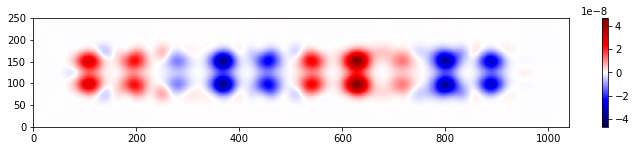

In [225]:
height = 6.0

plane_z = top_atom_z + height*ang_2_bohr
plane_index = int(np.round((plane_z - z_bottom)/dv[2]))

plt.figure(figsize=(12, int(eval_cell[1]/eval_cell[0]*12)))
plot_data = morb_grids[i_homo][:, :, plane_index].T
max_val = np.max(plot_data)
plt.pcolormesh(plot_data, vmax=max_val, vmin=-max_val, cmap='seismic')
plt.colorbar()
plt.show()

# Summing charge densities according to bias voltages

In [226]:
bias_arr = [-0.15, -0.1, -0.06, -0.005, 0.05, 0.15, 0.25, 0.35, 0.45]

In [227]:
charge_dens_arr = []
for bias in bias_arr:
    charge_dens = np.zeros(np.shape(morb_grids[0]))
    for imo, morb_grid in enumerate(morb_grids):
        if morb_energies[imo] > np.max([0.0, bias]):
            break
        if morb_energies[imo] >= np.min([0.0, bias]):
            charge_dens += morb_grid**2
    charge_dens_arr.append(charge_dens)

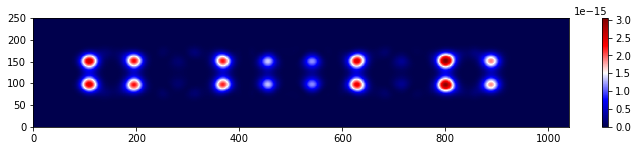

In [228]:
height = 6.0

plane_z = top_atom_z + height*ang_2_bohr
plane_index = int(np.round((plane_z - z_bottom)/dv[2]))

plt.figure(figsize=(12, int(eval_cell[1]/eval_cell[0]*12)))
plot_data = charge_dens_arr[3][:, :, plane_index].T
max_val = np.max(plot_data)
plt.pcolormesh(plot_data, vmax=max_val, vmin=0, cmap='seismic')
plt.colorbar()
plt.show()

In [229]:
def get_isosurf(data, value, z_vals, interp=True):
    rev_data = data[:, :, ::-1]
    rev_z_vals = z_vals[::-1]
    
    indexes = np.argmax(rev_data > value, axis=2)
    
    # IF indexes are 0, then it probably didn't find the correct value
    # And set it as the bottom surface
    indexes[indexes == 0] = len(z_vals) - 1
    
    if interp:
        z_val_plane = np.zeros(np.shape(rev_data)[0:2])
        for ix in range(np.shape(rev_data)[0]):
            for iy in range(np.shape(rev_data)[1]):
                ind = indexes[ix, iy]
                if ind == len(z_vals) - 1:
                    continue
                val_g = rev_data[ix, iy, ind]
                z_val_g = rev_z_vals[ind]
                val_s = rev_data[ix, iy, ind - 1]
                z_val_s = rev_z_vals[ind - 1]
                z_val_plane[ix, iy] = (value - val_s)/(val_g - val_s)*(z_val_g - z_val_s) + z_val_s
        return z_val_plane
    
    return rev_z_vals[indexes]

In [307]:
const_cur_imag = get_isosurf(charge_dens_arr[1], 5e-8, z_arr_loc, True)

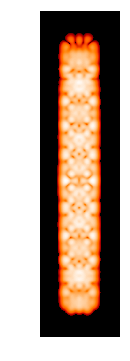

In [308]:
plt.figure(figsize=(eval_cell[1]/eval_cell[0]*6, 6))
plot_data = const_cur_imag
max_val = np.max(plot_data)

plt.pcolormesh(plot_data, vmax=max_val, vmin=20.0, cmap='gist_heat')
#plt.colorbar()
plt.axis('off')
plt.show()

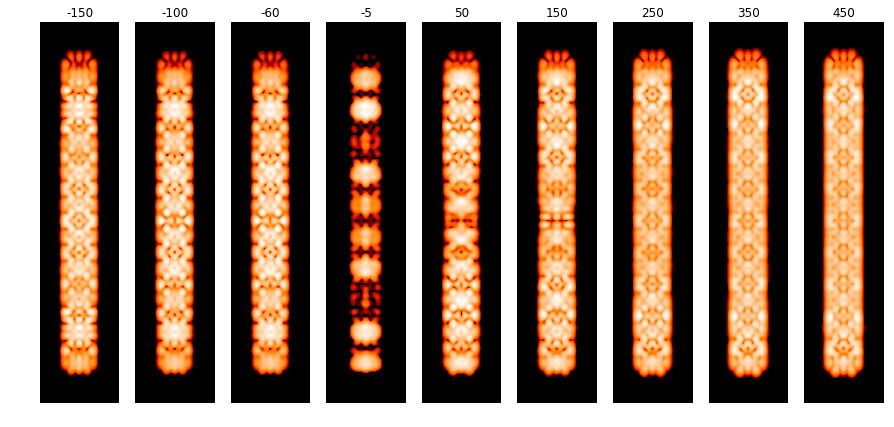

In [309]:
plt.figure(figsize=(eval_cell[1]/eval_cell[0]*7*9, 7))

for iv, volt in enumerate(bias_arr):
    plt.subplot(1, len(bias_arr), iv+1)
    
    const_cur_imag = get_isosurf(charge_dens_arr[iv], 5e-7, z_arr_loc, True)
    
    plot_data = const_cur_imag
    max_val = np.max(plot_data)

    plt.pcolormesh(plot_data, vmax=max_val, vmin=20.0, cmap='gist_heat')
    plt.title("%.0f"%(volt*1000))
    plt.axis('off')

plt.savefig('./fig/cc_stm.png', dpi=400, bbox_inches='tight')
plt.show()

In [275]:
morb_energies

array([ -1.01851232e-01,  -4.37026153e-02,  -2.58399245e-02,
        -1.19609068e-02,  -1.00430932e-02,  -4.83327795e-03,
        -2.58807523e-04,   8.56682890e-03,   1.30084630e-02,
         1.74417247e-02,   1.99750923e-02,   2.33914980e-02,
         2.56571951e-02,   4.36739258e-02,   9.72433665e-02,
         1.72408399e-01,   2.09212518e-01,   3.25223120e-01,
         3.30393155e-01,   4.46297670e-01])

In [132]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [134]:
rev_data[]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [137]:
indexes

array([[61, 61, 61, ..., 61, 61, 61],
       [61, 61, 61, ..., 61, 61, 61],
       [61, 61, 61, ..., 61, 61, 61],
       ..., 
       [61, 61, 61, ..., 61, 61, 61],
       [61, 61, 61, ..., 61, 61, 61],
       [61, 61, 61, ..., 61, 61, 61]])